# Решающие деревья

![](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2017/01/B03905_05_01-compressor.png?resize=768%2C424)

Решающие деревья - алгоритм МО, с помощью которого можно решать задачи классификации и регрессии. Основная идея алгортитма - это поиск условий принятия решений по тренировочным данным. У нас получается такое особое дерево поиска, в котором в узлах вопросы к данным на основе признаков, а в листовых узлах - метки классов. Во время обучения строится это дерево решений, причем так, чтобы оно было максимально эффективным - у него было хорошее качество предсказания и оно не было неоптимальным(слишком глубоким или несбалансированным).

## Литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

In [54]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

# Зафиксируем случайность, чтобы каждый раз получалось одно и тоже
np.random.seed(seed=42)

## Рассмотрим как строится дерево

In [55]:
from sklearn.tree import export_graphviz
import graphviz

In [56]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


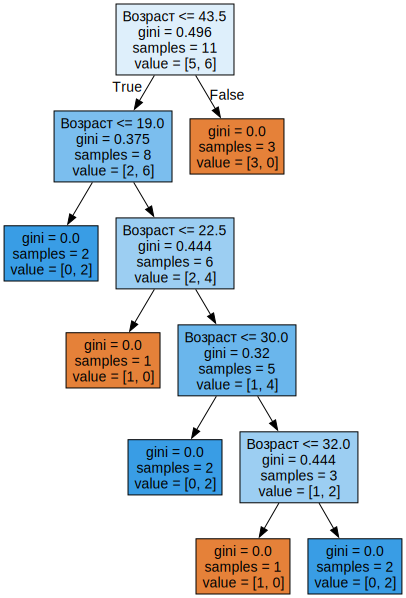

In [57]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values)

dot_data = export_graphviz(clf, feature_names=['Возраст'], filled=True, out_file=None)
graphviz.Source(dot_data) 

In [58]:
data2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

data2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


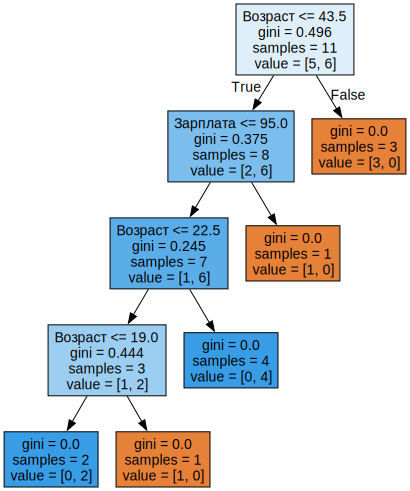

In [59]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values)

dot_data = export_graphviz(clf, feature_names=['Возраст', 'Зарплата'], filled=True, out_file=None)
graphviz.Source(dot_data) 

## Растим дерево

Прежде всего, для этого нам понадобится метрика неопределённости (impurity metric). 

Для классификации чаще всего предлагают следующие две:
<!-- 
![picture](https://drive.google.com/uc?export=view&id=1DjsVDWXvKPs-cLbl8y9o-OozD_a7u1U-) -->

- энтропия: $-\sum_k{p_{ik}log_2(p_{ik})}$

- индекс Джини: $\sum_{j\neq k}p_{ij}p_{ik} = 1 - \sum_k p_{ik}^2$

где $i$ - ID узлов дерева;

$k, j$ - идентификаторы классов, представленных в датасете;

$p_{ik} = \frac{N_{ik}}{N_i}$, 

$p_{ik}$ - вероятность принадлежности класса $k$ узлу $i$,

$N_{ik}$ - число объектов класса $k$ в узле $i$,

$N_{i}$ - общее число объектов в узле $i$.


In [60]:
import numpy as np

def gini_index(y):
    # Получаем уникальные значения (лейблы) и их количество
    labels, counts = np.unique(y, return_counts=True)
    # Вычисляем вероятности для каждого лейбла
    probabilities = counts / len(y)
    # Вычисляем индекс Джини по формуле: 1 - sum(p_i^2)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def entropy(y):
    # Получаем уникальные значения (лейблы) и их количество
    labels, counts = np.unique(y, return_counts=True)
    # Вычисляем вероятности для каждого лейбла
    probabilities = counts / len(y)
    # Вычисляем энтропию по формуле: -sum(p_i * log2(p_i))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

### Опишем такую структуру данных, как узел в дереве.
Он будет содержать значение целевого признака, некоторые метаданные (номер колонки признака, величину примеси, ссылки на левый и правый потомок в дереве(на всякий случай)) и уметь делать предсказание.

**Hint:** метод predict проверяет, является ли данный узел листом и в зависимости от этого либо возвращает значение, либо вызывает этот метод у дочерних узлов.

In [61]:
import numpy as np
import sys

class TreeNode:
    def __init__(self, impurity=sys.float_info.max, target_value=None):
        self.left_child = None  # левое ответвление
        self.right_child = None  # правое ответвление
        self.is_leaf = True  # флаг, является ли этот узел терминальным (то есть листом)

        self.target_value = target_value  # значение целевого признака, которое предсказывает этот узел дерева
        
        self.condition_column = None  # id столбца, по которому будет делаться ветвление в этом узле дерева
        self.condition_value = None  # значение, по которому будет делаться ветвление
        self.impurity = impurity  # значение неопределённости для этого узла

    def predict(self, x):
        if self.is_leaf:
            # Если узел терминальный, возвращаем целевое значение
            return np.full(x.shape[0], self.target_value)

        # Создаем маску для разделения данных
        mask = x[:, self.condition_column] >= self.condition_value

        # Создаем массив для хранения результатов
        res = np.zeros(x.shape[0])

        # Рекурсивно предсказываем для правого и левого поддеревьев
        res[mask] = self.right_child.predict(x[mask])
        res[~mask] = self.left_child.predict(x[~mask])

        return res

#### Теперь можно приступить к реализации алгоритма построения дерева.

На псевдокоде он выглядит вот так:
```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t
```
Как вы можете заметить, он рекурсивный.

Сначала напишем функцию, осуществляющую формирование одного узла дерева (ту самую, которую мы будем вызывать рекурсивно).

Прекращать дробление выборки и генерацию новых узлов будем, если
- В текущем узле все элементы относятся к одному классу
- Information Gain наилучшего возможного разбиения отрицательный

Information Gain ($IG$) определяется как

$ IG = S_{orig} - \frac{N_{left}}{N}S_{left} - \frac{N_{right}}{N}S_{right}$, где 

$S_{orig}$ - неопределённость для всей выборки на текущем шаге

$S_{left}, S_{right}$ - неопределённость на частях текущего разбиения

$\frac{N_{i}}{N}$ - доля подвыборки для $i$-й части разбиения относительно исходной выборки

В этой формуле $\frac{N_{left}}{N}S_{left} + \frac{N_{right}}{N}S_{right}$ - неопределённость для нового разбиения, давайте посчитаем его отдельно.

In [62]:
def new_split_impurity(s_left, s_right, impurity_metric):
    n_left = len(s_left)
    n_right = len(s_right)
    n_total = n_left + n_right

    # Вычисляем неопределённость для левой и правой частей
    impurity_left = impurity_metric(s_left)
    impurity_right = impurity_metric(s_right)

    # Взвешенная сумма неопределённостей
    total_impurity = (n_left / n_total) * impurity_left + (n_right / n_total) * impurity_right

    return total_impurity

In [63]:
a = np.asarray([0,0,1,1,1])
print('Default impurity is', gini_index(a))
l, r = np.split(a, [2])
print(f'Impurity after splitting into {l} and {r} is', new_split_impurity(l, r, gini_index))
del a, l, r

Default impurity is 0.48
Impurity after splitting into [0 0] and [1 1 1] is 0.0


Реализуйте функцию выбора класса для текущего листа.
Будет достаточно выбрать наиболее часто встречающийся класс, или один из таких.

Если хотите, можете придумать или найти какой-нибудь более хитрый метод.

In [64]:
def find_dominant_class(y):

    # Получаем уникальные значения и их количество
    unique_values, counts = np.unique(y, return_counts=True)
    # Находим индекс максимального количества
    dominant_index = np.argmax(counts)
    # Возвращаем доминирующий класс
    return unique_values[dominant_index]

In [65]:
print(f'The most common class is "{find_dominant_class([1,2,"кочерыжка", 1,"кочерыжка", "кочерыжка"])}"')

The most common class is "кочерыжка"


#### Теперь реализация алгоритма
Реализуйте метод построения дерева на основе описания, указанного выше.

Для этого Вам понадобится дополнительная функция, которая выбирает наиболее подходящее разбиение.

Разбиение в данной вариации делается по одному столбцу в данных. (Соответственно, нужно сначала подготавливать столбец к поиску разбиений)

In [66]:
def get_split_values(x):
    return np.unique(x)
        

def find_best_split(x, y, impurity_metric):
    min_impurity = np.inf
    best_split_col = 0
    best_split_value = None

    # Перебираем все столбцы
    for col in range(x.shape[1]):
        # Получаем уникальные значения для текущего столбца
        split_values = get_split_values(x[:, col])

        # Перебираем все возможные значения для разбиения
        for value in split_values:
            # Разделяем данные
            mask = x[:, col] >= value
            s_left = y[~mask]
            s_right = y[mask]

            # Пропускаем разбиения, где одна из частей пуста
            if len(s_left) == 0 or len(s_right) == 0:
                continue

            # Вычисляем неопределённость после разбиения
            current_impurity = new_split_impurity(s_left, s_right, impurity_metric)

            # Обновляем лучшее разбиение
            if current_impurity < min_impurity:
                min_impurity = current_impurity
                best_split_col = col
                best_split_value = value

    return min_impurity, best_split_col, best_split_value


def build_next_node(x, y, impurity_metric, depth=0, max_depth=5):
    # Если достигнута максимальная глубина или все метки одинаковы, создаём лист
    if depth >= max_depth or len(np.unique(y)) == 1:
        return TreeNode(target_value=find_dominant_class(y))

    # Находим лучшее разбиение
    min_impurity, best_split_col, best_split_value = find_best_split(x, y, impurity_metric)

    # Если не удалось найти разбиение, создаём лист
    if best_split_value is None:
        return TreeNode(target_value=find_dominant_class(y))

    # Создаём узел
    node = TreeNode()
    node.is_leaf = False
    node.condition_column = best_split_col
    node.condition_value = best_split_value
    node.impurity = min_impurity

    # Разделяем данные
    mask = x[:, best_split_col] >= best_split_value
    x_left, y_left = x[~mask], y[~mask]
    x_right, y_right = x[mask], y[mask]

    # Рекурсивно строим левое и правое поддеревья
    node.left_child = build_next_node(x_left, y_left, impurity_metric, depth + 1, max_depth)
    node.right_child = build_next_node(x_right, y_right, impurity_metric, depth + 1, max_depth)

    return node

## Визуализация предсказаний

Рассмотрим как справляются с задачей классификации 3 алгоритма - линейный, ближайшие соседи и решающее дерево на синтетическом примере - две луны и кольца.

In [67]:
# Вспомогательная функция для генерации точек на всей поверхности scatter plot
def get_grid(X, y, step=0.01):
    x_min, x_max = X.min() - 1, X.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

# Вспомогательная функция которая покрасит всё пространство
def fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=True, step=0.01):
    xx, yy = get_grid(X, y, step)
    if proba and hasattr(clf, 'predict_proba'):
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, predicted, cmap=cmap, alpha=.8)

Text(0, 0.5, 'Зарплата')

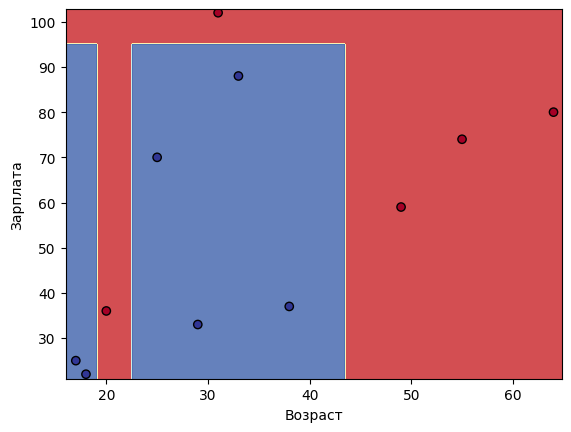

In [68]:
fill_color(clf, data2['Возраст'], data2['Зарплата'], cmap=plt.cm.RdYlBu, proba=False, step=0.2)
plt.scatter(data2['Возраст'], data2['Зарплата'], c=data2['Невозврат кредита'], cmap=plt.cm.RdYlBu, edgecolors='k')
plt.xlabel('Возраст')
plt.ylabel('Зарплата')

In [69]:
from sklearn.datasets import make_moons, make_circles, make_classification

## Две Луны

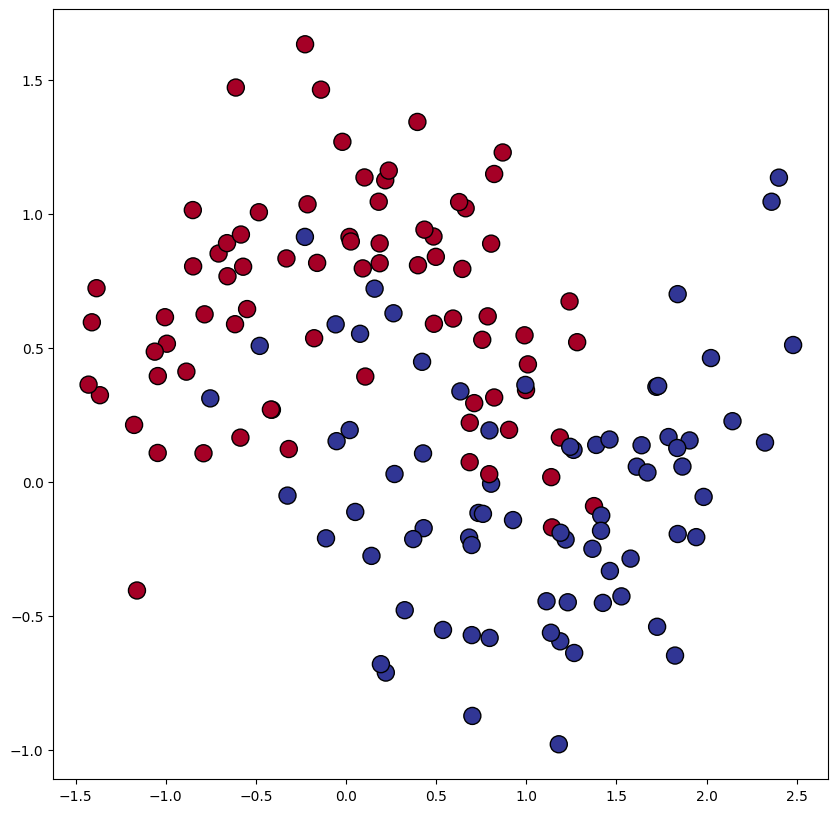

In [70]:
X, y = make_moons(n_samples=150, noise=0.3, random_state=42)

plt.figure(figsize=(10,10))

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

Для начала посмотрим, как с задачей справится линейная регрессия. Дополнительно вызвав функцию `fill_color` покрасим все пространство, чтобы видеть как меняется решение модели, на основе плавного изменения признка.  
Понятно, почему мы видим линии как разделители поверхностей. У нас же линейная модель!

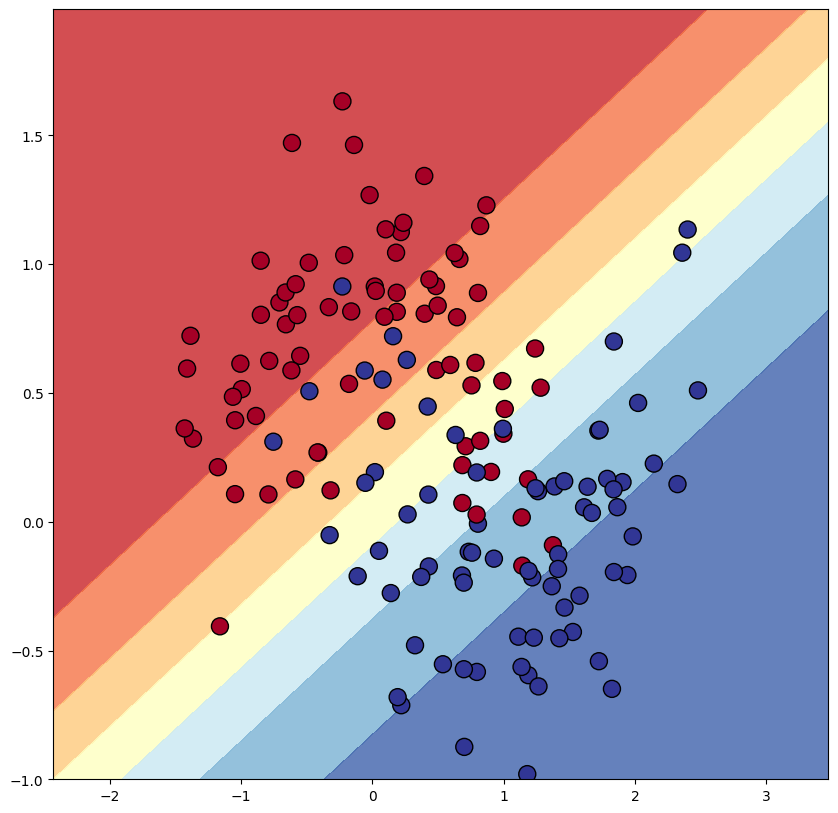

In [71]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

А K ближайших соседей работает немного по-другому. Видно, что это модель может уловить нелинейную взаимосвзять между признаками и целевым признаком. Пространство предсказания разукрасилось плавно.

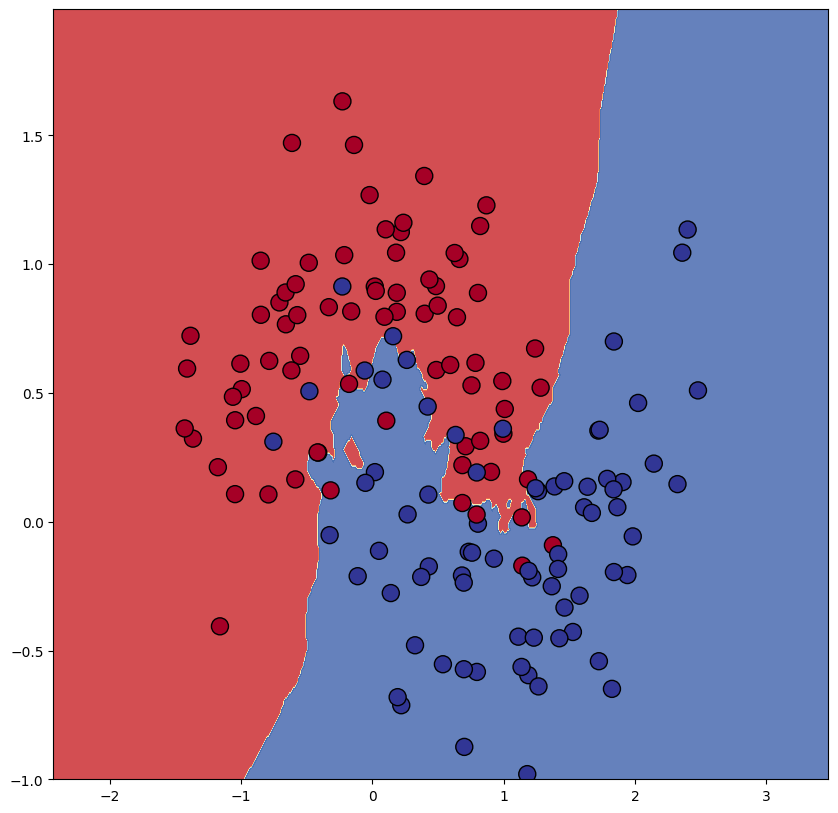

In [72]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(7)
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

Решающие деревья разбивают пространство на прямоугольники, "выцепляя" объекты.

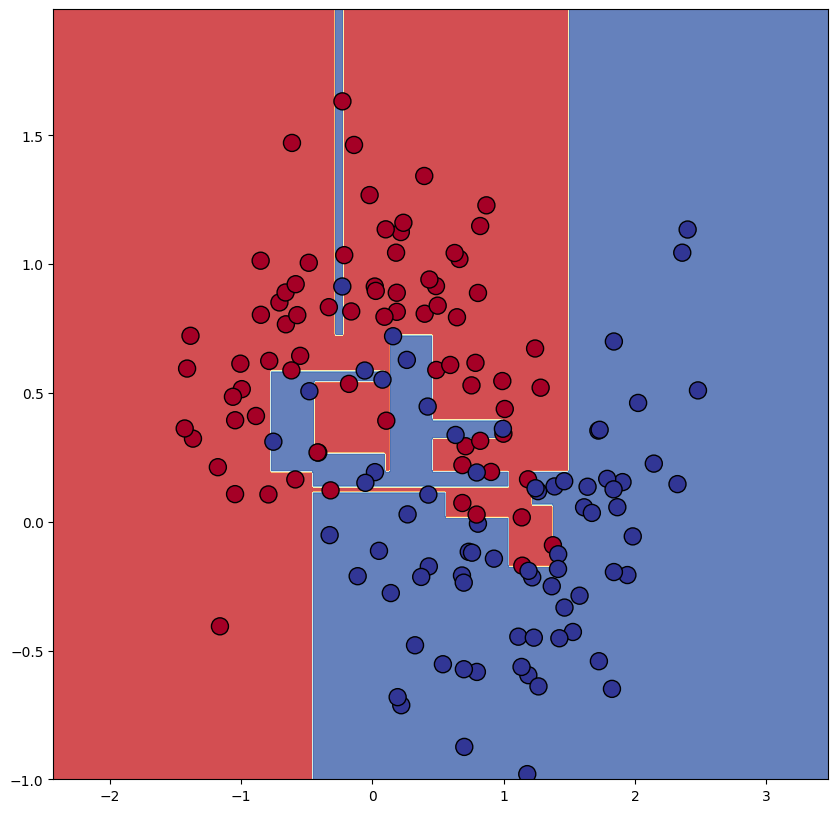

In [73]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

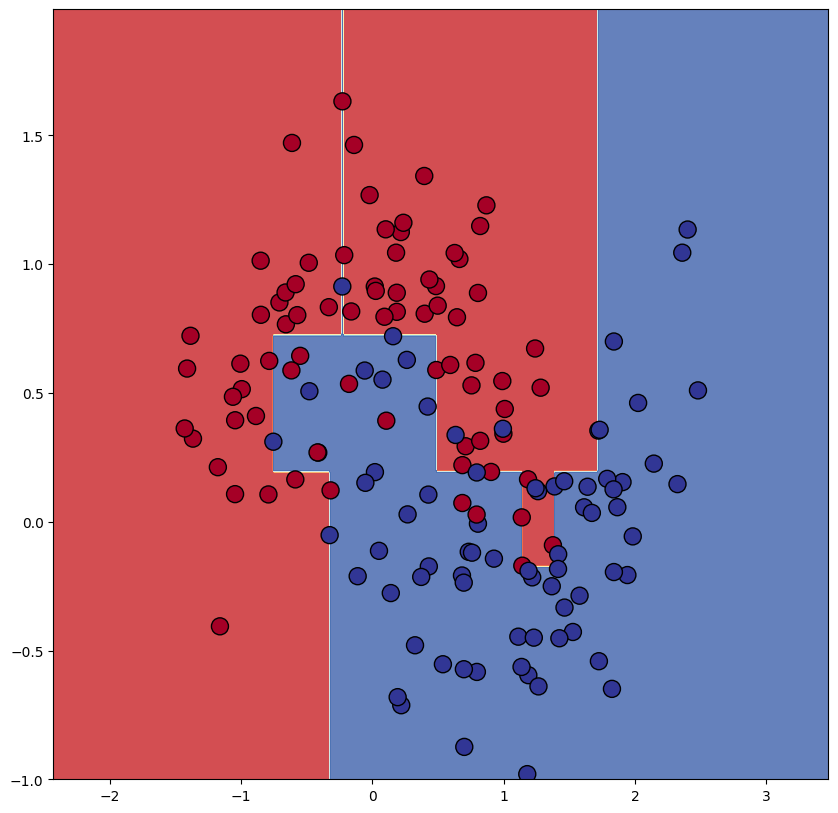

In [74]:
clf = build_next_node(X, y, gini_index)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

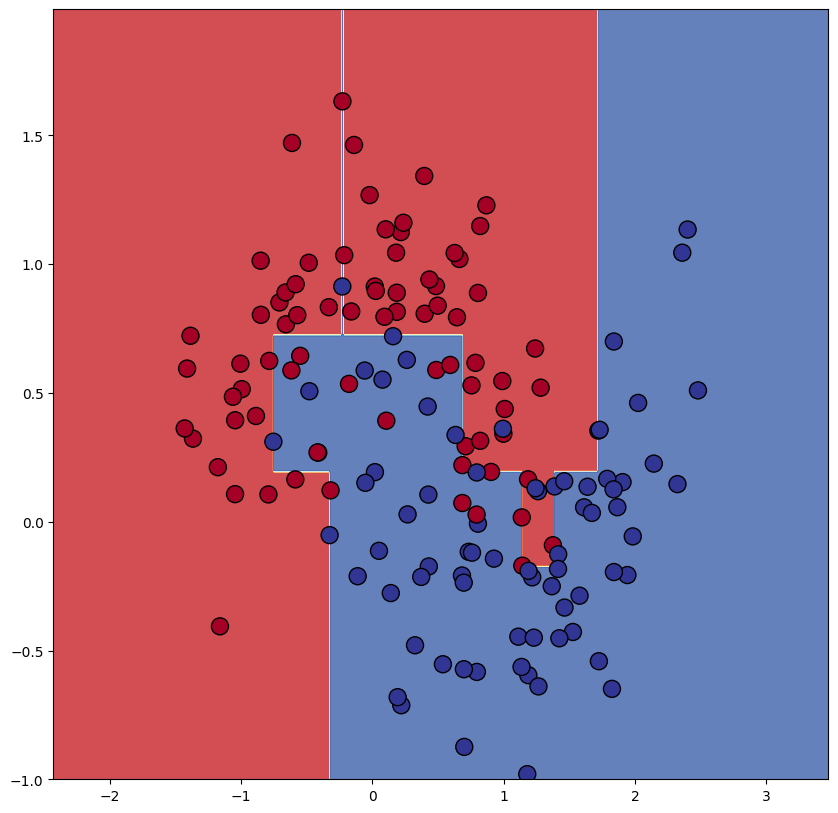

In [75]:
clf = build_next_node(X, y, entropy)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

## Кольца

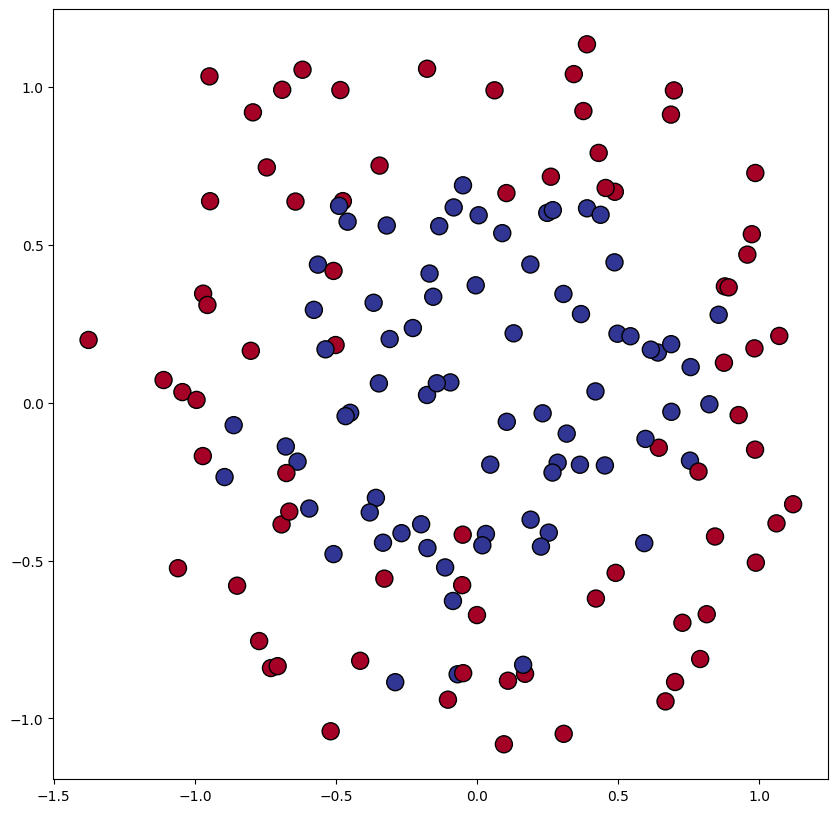

In [76]:
X, y = make_circles(n_samples=150, noise=0.2, factor=0.5, random_state=1)

plt.figure(figsize=(10,10))

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

Линейной модели совсем сложно справиться с такой задачей, так как объекты невозможно отделить одной прямой линией. (Но если применить трюк с переходом в другие координаты......)

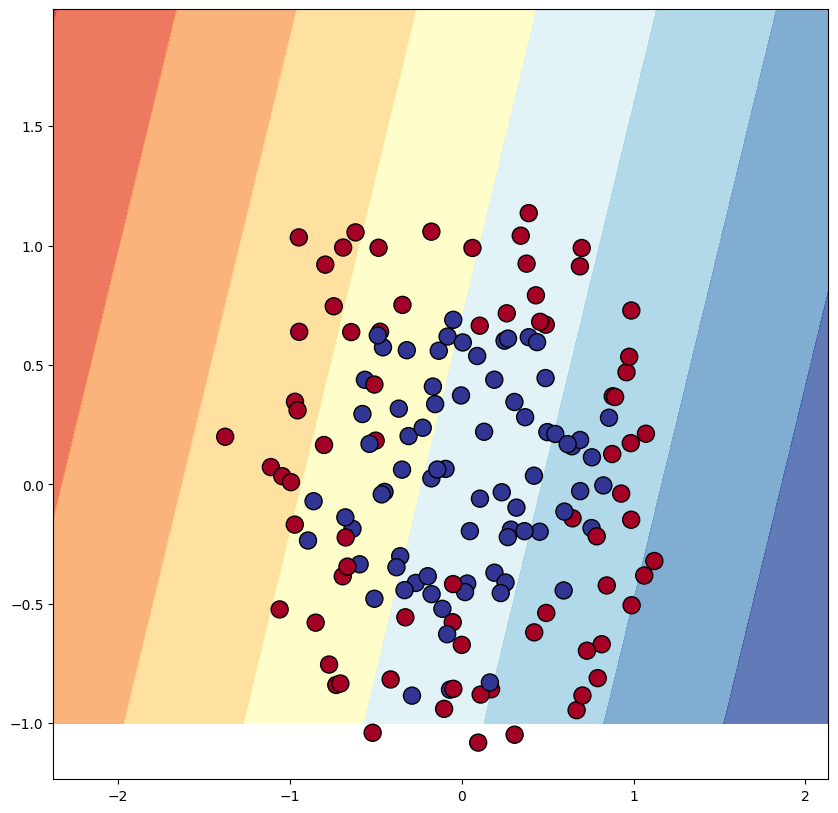

In [77]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

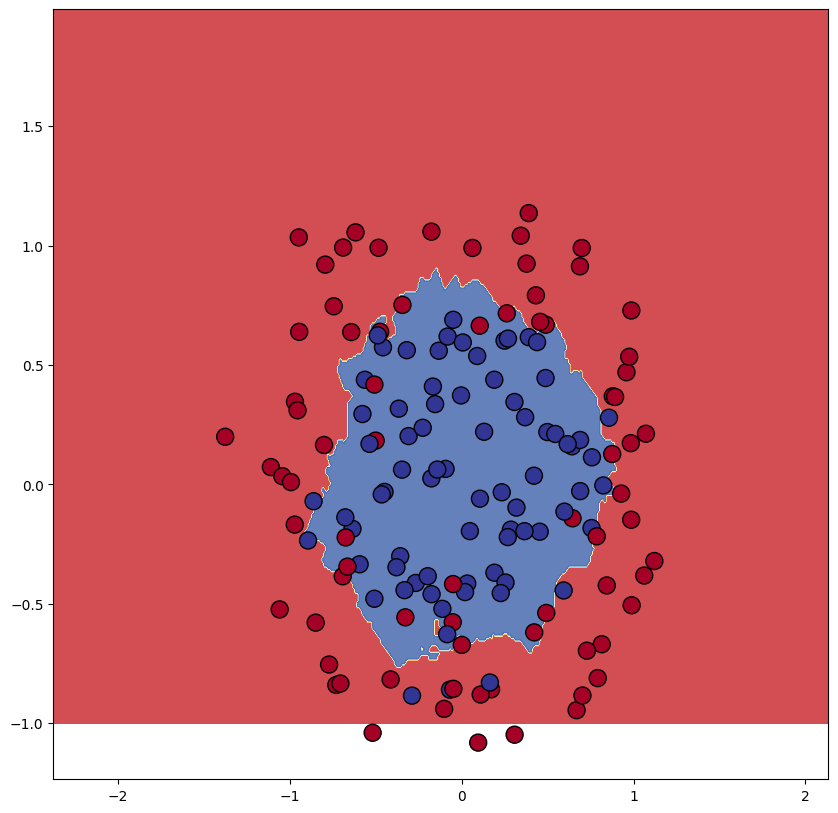

In [78]:
clf = KNeighborsClassifier(7)
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

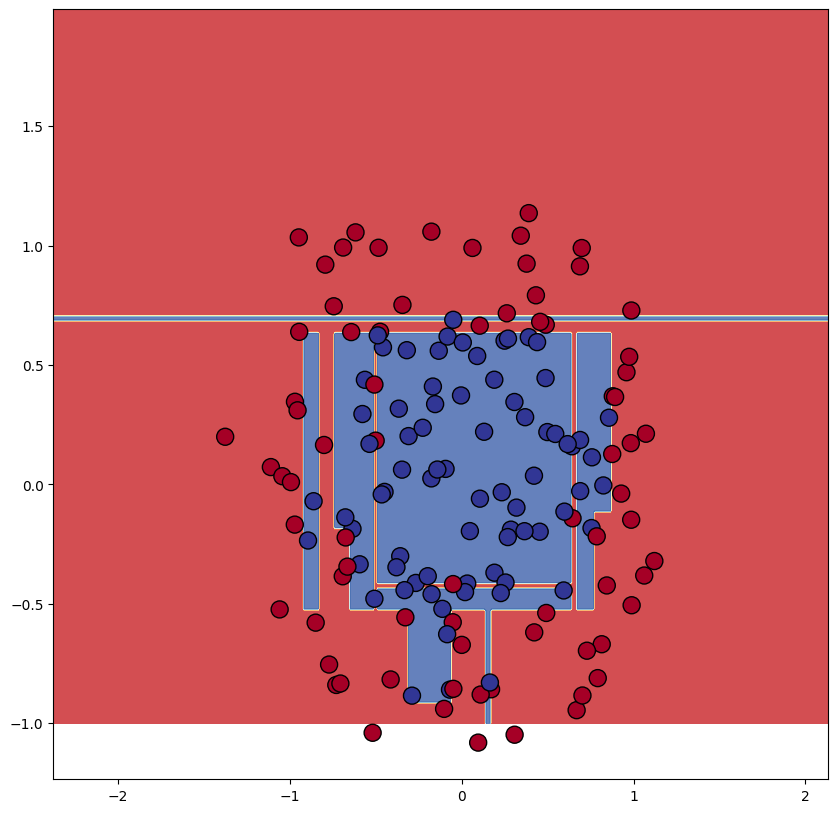

In [79]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

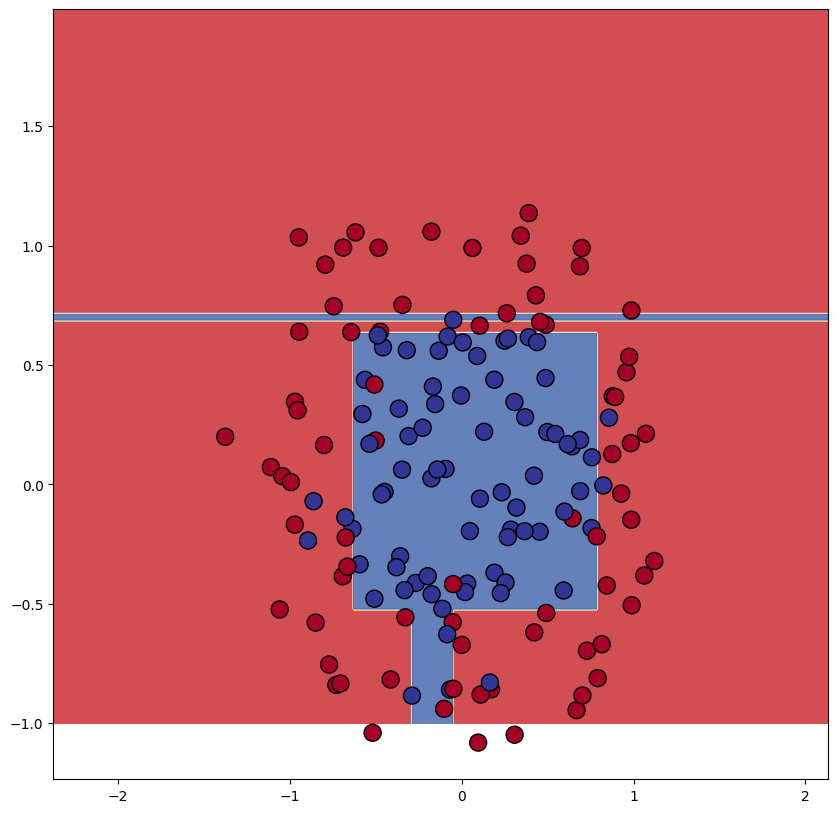

In [80]:
clf = build_next_node(X, y, gini_index)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

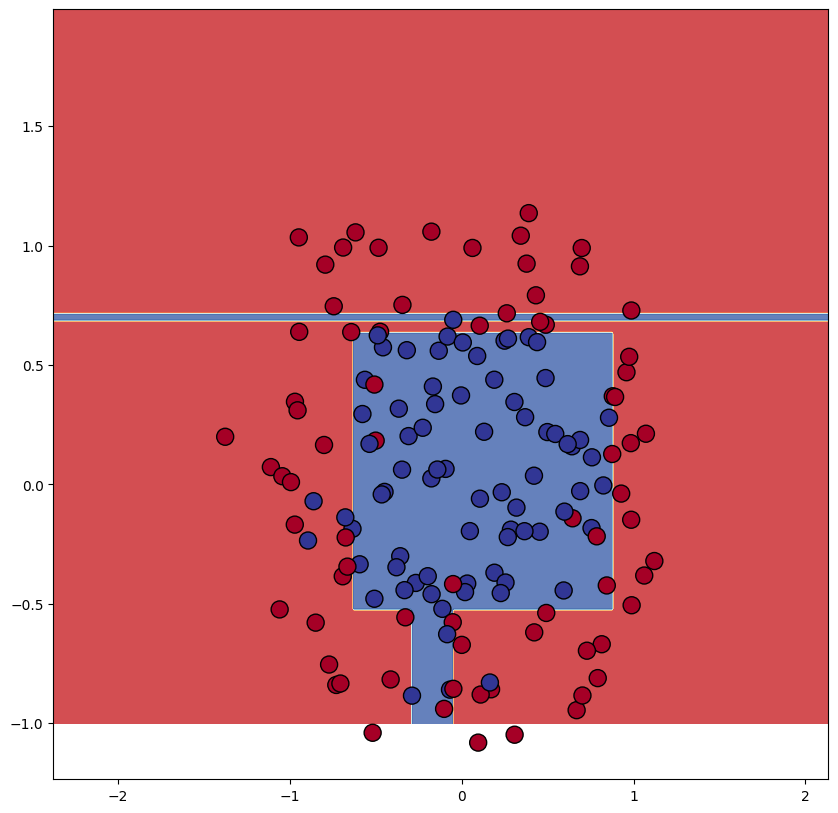

In [81]:
clf = build_next_node(X, y, entropy)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

## Неустойчивость деревьев

Неустойчивость к изменениям в данных.

В отличие от весьма стабильных алгоритмов kNN и линейной классификации, дерево решений очень сильно меняется в зависимости от фазы луны и формы данных. Если мы добавим еще один элемент, то может всё сильно измениться, давайте посмотрим!

**Спойлер**: но этот недостаток делает их сильнее, когда их много!!

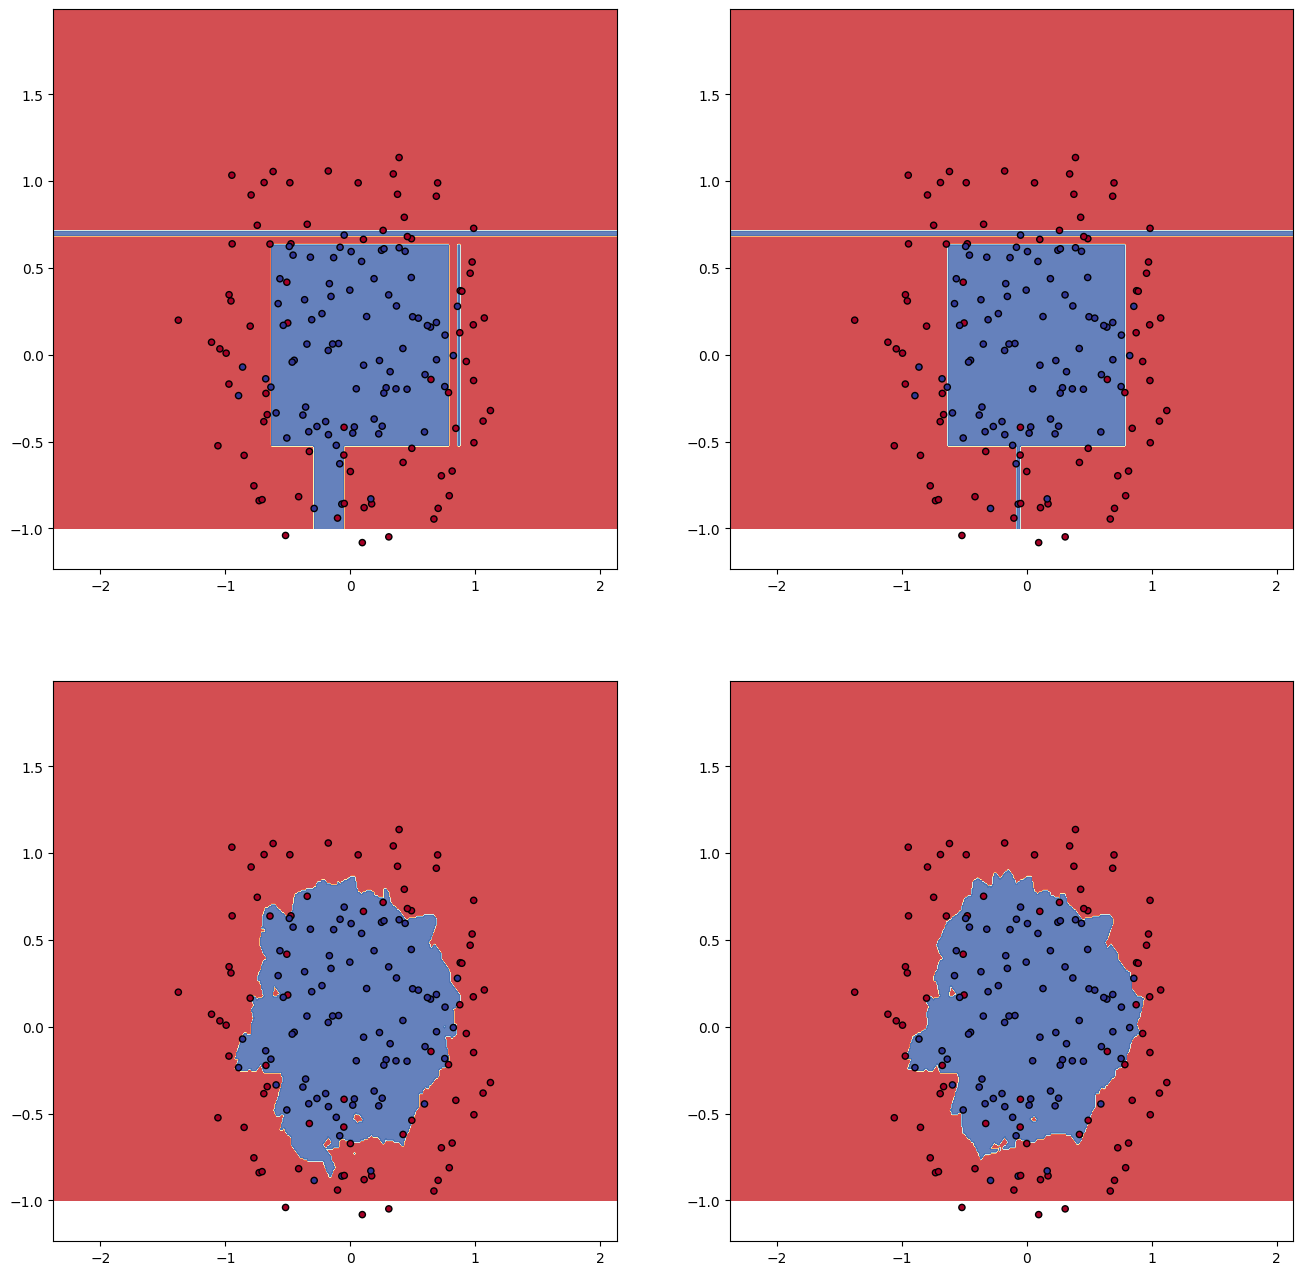

In [82]:
X, y = make_circles(n_samples=150, noise=0.2, factor=0.5, random_state=1)

plt.figure(figsize=(16,16))


#################### Tree ##################

clf = build_next_node(X[10:], y[10:], gini_index)
plt.subplot(221)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

clf = build_next_node(X[:140], y[:140], gini_index)
plt.subplot(222)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

#################### KNN ########################

clf = KNeighborsClassifier(5)
clf.fit(X[10:], y[10:])
plt.subplot(223)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

clf = KNeighborsClassifier(5)
clf.fit(X[:140], y[:140])
plt.subplot(224)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

## Регрессия


Теперь реализуем метрику под названием Остаточная Сумма Квадратов (Residual sum of squares).

$RSS = \sum_{j=1}^N(y_j - \mu_{[j]})^2$

где $\mu_{[j]}$ - это среднее всех значений в листе из разбиения, к которому принадлежит $j$-й элемент.

In [83]:
def residual_sum_of_squares(y):
    # Вычисляем среднее значение в листе
    mu = np.mean(y)
    # Вычисляем RSS
    rss = np.sum((y - mu) ** 2)
    return rss

Теперь настало время переделать нашу функцию под регрессию. Первая и самая важная вещь, которую стоит помнить это то, что в отличие от классификации, здесь все значения могут быть уникальными и их может быть бесконечно много (если, конечно, игнорировать ограничения, диктуемые нам "железом").

Давайте вспомним наши критерии останова, взятые для классификации:
- В текущем узле все элементы относятся к одному классу
- Information Gain наилучшего возможного разбиения отрицательный

Сразу же можно понять, что первый критерий теперь не подходит нам, т.к. он всегда будет приводить нас к переобученному дереву (тому, у которого на каждый элемент выборки приходится свой отдельный лист)
В такой ситуации возможны, как минимум, три выхода:
1. Оставить его как есть и получать в конце переобученное дерево (впрочем, в sklearn так и делают)
2. Ввести дополнительные ограничения, например на глубину дерева, минимальное количество объектов, относящихся к каждому листу дерева (есть в sklearn как опции)
3. Останавливать обучение, когда достигнута какая-то величина метрики неопределённости - по сути говоря, это почти то же самое, что задавать максимальную допустимую величину разности между двумя произвольными объектами в этом разбиении. Такой способ не требует никаких дополнительных условий, но это не очень надёжный способ, т.к. величина RSS напрямую зависит от масштаба характеристических признаков.

Ещё можно "обрезать" переобученное дерево после построения, как советовали Брейман и Ко в описании алгоритма CART. Но это уже совсем другая история...

Так, ладно, сначала попробуем натренировать дерево регрессии не меняя алгоритм. Оно должно получиться глубоким, но точным.

Для этого загрузим датасет с ценами на жильё в Бостоне. Будем тестировать модель, предсказывая медианное значение цены на несъёмное жильё.

In [88]:
from sklearn.datasets import load_diabetes

data = load_diabetes()
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [89]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = data.target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,MEDV
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [90]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(df.drop(['MEDV'], axis=1), df['MEDV'], test_size=100, 
                                        random_state=241)

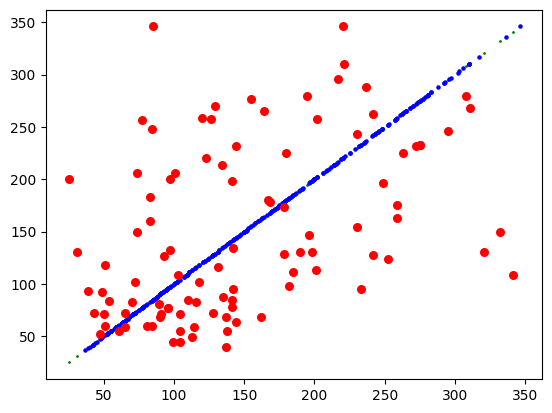

In [91]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()
clf.fit(X, y)

plt.scatter(y_test, y_test, color='green', s=1)  # идеальная прямая, чтобы было
plt.scatter(y, clf.predict(X), color='blue', s=5)
plt.scatter(y_test, clf.predict(X_test), color='red', s=30)

Выведем, сколько у дерева получилось листьев.

In [92]:
clf.get_n_leaves()

333

Сейчас мы попробоуем запустить нашу старую функцию, которая предназначается для классификации. Там есть один важный нюанс, который скорее всего всё испортит, но всё равно давайте попробуем.

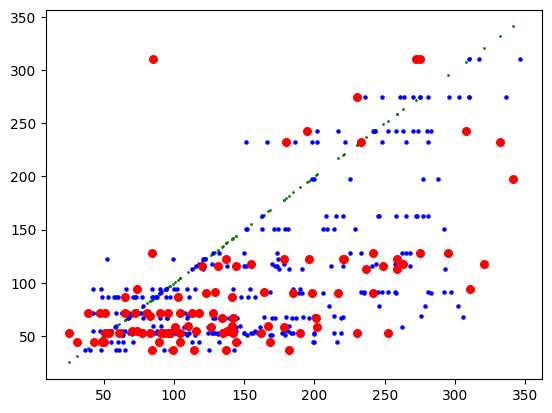

In [93]:
try:
    clf = build_next_node(X.to_numpy(), y.to_numpy(), residual_sum_of_squares)

    plt.scatter(y_test, y_test, color='green', s=1)  # идеальная прямая, чтобы было
    plt.scatter(y, clf.predict(X.to_numpy()), color='blue', s=5)
    plt.scatter(y_test, clf.predict(X_test.to_numpy()), color='red', s=30)
except:
    print('A Fail has happened. We are doomed to implement a version for regression.')

Для нашего дерева нужен метод, чтобы посчитать листья, он уже готов.

In [94]:
def count_leaves(node):
    if node.is_leaf:
        return 1
    return count_leaves(node.left_child) + count_leaves(node.right_child)

In [95]:
count_leaves(clf)

32

А теперь давайте сделаем "правильную" версию с регрессией. Можно использовать старый метод, изменить нужно всего-лишь пару строк.

In [99]:
def build_next_node_regression(x, y, impurity_metric, depth=0, max_depth=5):
    """
    Рекурсивно строит дерево решений для задачи регрессии.

    Параметры:
    -----------
    x : numpy.ndarray
        Массив признаков.
    y : numpy.ndarray
        Массив целевых значений.
    impurity_metric : function
        Функция для вычисления неопределённости (например, residual_sum_of_squares).
    depth : int
        Текущая глубина дерева.
    max_depth : int
        Максимальная глубина дерева.

    Возвращает:
    -----------
    TreeNode
        Корень построенного поддерева.
    """
    # Если достигнута максимальная глубина или все значения y одинаковы, создаём лист
    if depth >= max_depth or len(np.unique(y)) == 1:
        return TreeNode(target_value=np.mean(y))  # В регрессии предсказываем среднее значение

    # Находим лучшее разбиение
    min_impurity, best_split_col, best_split_value = find_best_split(x, y, impurity_metric)

    # Если не удалось найти разбиение, создаём лист
    if best_split_value is None:
        return TreeNode(target_value=np.mean(y))

    # Создаём узел
    node = TreeNode()
    node.is_leaf = False
    node.condition_column = best_split_col
    node.condition_value = best_split_value
    node.impurity = min_impurity

    # Разделяем данные
    mask = x[:, best_split_col] >= best_split_value
    x_left, y_left = x[~mask], y[~mask]
    x_right, y_right = x[mask], y[mask]

    # Рекурсивно строим левое и правое поддеревья
    node.left_child = build_next_node_regression(x_left, y_left, impurity_metric, depth + 1, max_depth)
    node.right_child = build_next_node_regression(x_right, y_right, impurity_metric, depth + 1, max_depth)

    return node

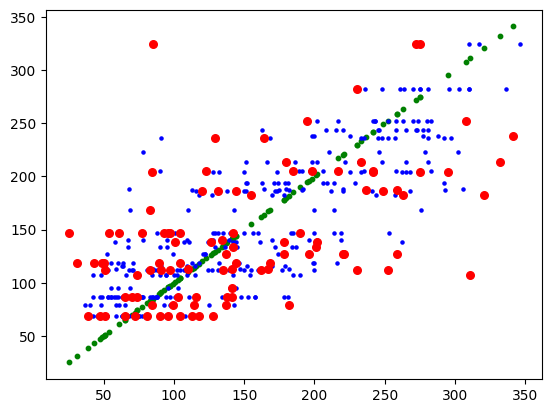

In [100]:
clf = build_next_node_regression(X.to_numpy(), y.to_numpy(), residual_sum_of_squares)

plt.scatter(y_test, y_test, color='green', s=10)  # идеальная прямая, чтобы было
plt.scatter(y, clf.predict(X.to_numpy()), color='blue', s=5)
plt.scatter(y_test, clf.predict(X_test.to_numpy()), color='red', s=30)

In [101]:
count_leaves(clf)

32

### А что дальше?

Над деревьями можно делать много разных модификаций:
- Урезать глубину дерева
- Запрещать создавать листья с менее чем $k$ элементами выборки на них
- модифицировать логику выбора класса, если на листе есть элементы разных классов
    - Вычислить вероятности выпадения каждого класса, тем самым задав распределение, и затем, при попадании на этот лист генерировать случайную величину из этого распределения, и считать это предсказанием
    - Так же, вычислить вероятности, а величину выбрать один раз сгенерировав случайную величину
- Объединить много таких деревьев в ансамбли (пожалуй, наиболее перспективная идея)
